# Implment CIELAB with CSV (gimp color lookup)

In [ ]:
# === DIE COLOR SEGMENTATION (Lab/RGB) — JUPYTER READY ===
# - Accepts CSV samples as either CIELAB floats (L 0..100, a/b ~ -128..+127) or RGB 0..255
# - Auto-detects based on values/filename; you can force via samples_space='lab_gimp' or 'rgb'
# - Outputs: masks per class, color label map, overlay; shows inline

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module=r"matplotlib\.projections",
    message=r"^Unable to import Axes3D\."
)

# --------- CSV loading ---------
def read_samples_csv_any(path):
    """
    Reads headerless CSV lines of the form:
      class,val1,val2,val3
    - Allows floats and negatives (for Lab).
    - Ignores blank lines and lines starting with '#'.
    Returns:
      classes: (N,) array of class names (str)
      vals:    (N,3) float32 array
    """
    rows = []
    with open(path, "r") as f:
        for ln in f:
            ln = ln.strip()
            if not ln or ln.startswith("#"):
                continue
            parts = [p.strip() for p in ln.split(",")]
            if len(parts) < 4:
                continue
            cls = parts[0]
            v1, v2, v3 = map(float, parts[1:4])
            rows.append((cls, v1, v2, v3))
    if not rows:
        raise ValueError("No valid sample rows found in CSV.")
    classes = np.array([r[0] for r in rows], dtype=object)
    vals    = np.array([[r[1], r[2], r[3]] for r in rows], dtype=np.float32)
    return classes, vals

def guess_samples_space(path, vals):
    """
    Guess whether samples are 'lab_gimp' (CIELAB floats) or 'rgb'.
    Heuristics:
      - filename contains 'lab'  -> lab_gimp
      - any value < 0 or > 255   -> lab_gimp
      - median L <= 100 AND any a/b < 0 -> lab_gimp
      - else rgb
    """
    name = os.path.basename(path).lower()
    if "lab" in name:
        return "lab_gimp"
    if np.any(vals < 0) or np.any(vals > 255):
        return "lab_gimp"
    if (np.median(vals[:,0]) <= 100 and np.any(vals[:,1:] < 0)):
        return "lab_gimp"
    return "rgb"

# --------- Color conversions ---------
def gimp_lab_to_cv_lab(lab_vals):
    """
    Convert CIELAB (as GIMP shows: L in 0..100, a/b ≈ -128..+127)
    to OpenCV's Lab encoding used by cv2.cvtColor:
      L_cv in 0..255 (L* scaled by 255/100)
      a_cv in 0..255 with 128 = 0
      b_cv in 0..255 with 128 = 0
    """
    L = lab_vals[:, 0]
    a = lab_vals[:, 1]
    b = lab_vals[:, 2]
    L_cv = L * (255.0 / 100.0)
    a_cv = a + 128.0
    b_cv = b + 128.0
    return np.stack([L_cv, a_cv, b_cv], axis=1).astype(np.float32)

def rgb_to_lab_fixed(rgb_uint8):
    """
    Vectorized RGB[0..255] -> OpenCV Lab float32.
    OpenCV expects BGR; shape should be (H,W,3). We fake H=N, W=1.
    """
    rgb = rgb_uint8.reshape(-1, 1, 3).astype(np.uint8)  # (N,1,3)
    bgr = rgb[..., ::-1]
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB).reshape(-1, 3).astype(np.float32)
    return lab

# --------- Stats & classification ---------
def fit_gaussian_per_class(classes, lab_samples, eps=1e-3):
    """
    Fit a 3D Gaussian in OpenCV Lab space for each class.
    Returns dict[class] = {mu, cov_inv, logdet}
    """
    stats = {}
    for cls in np.unique(classes):
        X = lab_samples[classes == cls].astype(np.float32)
        mu = X.mean(axis=0)
        if X.shape[0] > 1:
            cov = np.cov(X.T)
        else:
            cov = np.eye(3, dtype=np.float32)
        cov = cov.astype(np.float32) + np.eye(3, dtype=np.float32) * eps
        cov_inv = np.linalg.inv(cov)
        sign, logdet = np.linalg.slogdet(cov)
        stats[cls] = dict(mu=mu, cov_inv=cov_inv, logdet=logdet)
    return stats

def mahalanobis_squared(X, mu, cov_inv):
    d = X - mu
    return np.einsum('...i,ij,...j->...', d, cov_inv, d)

def classify_lab_image(lab_img, stats, priors=None, use_likelihood=True):
    """
    lab_img: HxWx3 float32 in OpenCV Lab encoding
    stats:   dict from fit_gaussian_per_class
    priors:  optional dict {class_name: weight} (multiplicative; applied as log)
    Returns:
      label_map (H,W) int32 indices
      class_names (list of str)
    """
    H, W, _ = lab_img.shape
    X = lab_img.reshape(-1, 3).astype(np.float32)
    class_names = list(stats.keys())  # preserves insertion order
    K = len(class_names)
    ll = np.zeros((X.shape[0], K), dtype=np.float32)

    logw = np.zeros(K, dtype=np.float32)
    if priors:
        for k, cls in enumerate(class_names):
            w = float(priors.get(cls, 1.0))
            logw[k] = np.log(max(w, 1e-6))

    for k, cls in enumerate(class_names):
        s = stats[cls]
        d2 = mahalanobis_squared(X, s["mu"], s["cov_inv"])
        ll[:, k] = -0.5 * (d2 + s["logdet"])  # Gaussian log-likelihood up to a constant

    if priors:
        ll += logw[None, :]

    label_idx = np.argmax(ll if use_likelihood else -ll, axis=1)
    return label_idx.reshape(H, W).astype(np.int32), class_names

# --------- Visualization & postprocess ---------
def colorize_labels(label_map, class_names):
    """
    Map class indices to a stable RGB palette.
    """
    palette = [
        ( 60,180, 75),  # green
        (230, 25, 75),  # red
        (255,225, 25),  # yellow
        ( 67, 99,216),  # blue
        (245,130, 49),  # orange
        (145, 30,180),  # purple
        ( 70,240,240),  # cyan
        (240, 50,230),  # pink
    ]
    H, W = label_map.shape
    out = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(len(class_names)):
        out[label_map == i] = palette[i % len(palette)]
    return out

def postprocess_mask(mask_u8, median_ks=3, open_ks=3, close_ks=3):
    """
    mask_u8: uint8 0/255
    """
    m = mask_u8.copy()
    if median_ks and median_ks > 1 and (median_ks % 2 == 1):
        m = cv2.medianBlur(m, median_ks)
    if open_ks and open_ks > 1:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_ks, open_ks))
        m = cv2.morphologyEx(m, cv2.MORPH_OPEN, k)
    if close_ks and close_ks > 1:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_ks, close_ks))
        m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, k)
    return m

def compute_area_stats(label_map, class_names):
    """
    Returns dict {class_name: (count, percent)} sorted by size desc.
    """
    H, W = label_map.shape
    total = H * W
    stats = {}
    for i, cls in enumerate(class_names):
        cnt = int(np.sum(label_map == i))
        pct = 100.0 * cnt / max(total, 1)
        stats[cls] = (cnt, pct)
    # sort by count desc
    return dict(sorted(stats.items(), key=lambda kv: kv[1][0], reverse=True))

# --------- Main entry for notebooks ---------
def segment_and_save(image_path, csv_path, outdir="out",
                     median_ks=3, open_ks=3, close_ks=3,
                     priors=None, overlay_alpha=0.45, show=True,
                     samples_space="auto"):
    """
    Run color-band segmentation using per-class Gaussians in OpenCV Lab space.

    Args:
      image_path: path to flat-field corrected image
      csv_path:   sample CSV. If samples_space='lab_gimp', rows are CIELAB floats (L,a,b).
                  If 'rgb', rows are RGB (0..255).
      outdir:     output directory (created if missing)
      median_ks/open_ks/close_ks: postprocessing kernels (0 disables)
      priors:     optional dict {class_name: weight} to bias classification
      overlay_alpha: alpha for label overlay (0..1)
      show:       display original + overlay inline
      samples_space: 'auto' | 'lab_gimp' | 'rgb'

    Returns:
      label_map (H,W) int32
      class_names list[str]
      paths dict of saved outputs
      area_stats dict {class: (count, percent)}
    """
    os.makedirs(outdir, exist_ok=True)

    # Load image and convert full image to Lab
    img_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise FileNotFoundError(f"Could not read image: {image_path}")
    lab_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB).astype(np.float32)

    # Load samples
    classes, vals = read_samples_csv_any(csv_path)

    # Decide sample space
    space = samples_space if samples_space != "auto" else guess_samples_space(csv_path, vals)

    # Convert samples to OpenCV Lab encoding
    if space == "lab_gimp":
        labs = gimp_lab_to_cv_lab(vals.astype(np.float32))
    elif space == "rgb":
        vals_u8 = np.clip(vals, 0, 255).astype(np.uint8)
        labs = rgb_to_lab_fixed(vals_u8)
    else:
        raise ValueError(f"Unknown samples_space: {samples_space}")

    # Fit per-class Gaussians and classify
    stats = fit_gaussian_per_class(classes, labs)
    label_map, class_names = classify_lab_image(lab_img, stats, priors=priors, use_likelihood=True)

    # Save colorized labels
    labels_rgb = colorize_labels(label_map, class_names)
    labels_path = os.path.join(outdir, "labels_color.png")
    cv2.imwrite(labels_path, cv2.cvtColor(labels_rgb, cv2.COLOR_RGB2BGR))

    # Save per-class masks (postprocessed)
    paths = {"labels_color": labels_path}
    for idx, cls in enumerate(class_names):
        raw  = (label_map == idx).astype(np.uint8) * 255
        proc = postprocess_mask(raw, median_ks=median_ks, open_ks=open_ks, close_ks=close_ks)
        pth  = os.path.join(outdir, f"mask_{cls}.png")
        cv2.imwrite(pth, proc)
        paths[f"mask_{cls}"] = pth

    # Blended overlay
    color_lbl_bgr = cv2.cvtColor(labels_rgb, cv2.COLOR_RGB2BGR)
    overlay = cv2.addWeighted(color_lbl_bgr, overlay_alpha, img_bgr, 1 - overlay_alpha, 0)
    overlay_path = os.path.join(outdir, "overlay.png")
    cv2.imwrite(overlay_path, overlay)
    paths["overlay"] = overlay_path

    # Legend
    legend_path = os.path.join(outdir, "classes.txt")
    with open(legend_path, "w") as f:
        for i, cls in enumerate(class_names):
            f.write(f"{i}: {cls}\n")
    paths["legend"] = legend_path

    # Area stats
    area_stats = compute_area_stats(label_map, class_names)

    # Show inline
    if show:
        fig = plt.figure(figsize=(14, 6))
        ax1 = fig.add_subplot(1,2,1)
        ax1.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
        ax1.set_title("Original"); ax1.axis('off')
        ax2 = fig.add_subplot(1,2,2)
        ax2.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        ax2.set_title("Overlay"); ax2.axis('off')
        plt.show()

        # Print quick stats
        print(f"[samples_space detected = {space}]")
        for cls, (cnt, pct) in area_stats.items():
            print(f"{cls:>12}: {cnt:9d}  ({pct:6.2f}%)")

    return label_map, class_names, paths, area_stats

# ---- Example call (uncomment and edit paths) ----
# label_map, class_names, paths, stats = segment_and_save(
#     image_path="./images/die_flat.jpg",
#     csv_path="./color_sample_lab.csv",
#     outdir="out-lab",
#     median_ks=3, open_ks=3, close_ks=3,
#     priors=None,            # e.g., {"substrate": 1.2}
#     overlay_alpha=0.45,
#     show=True,
#     samples_space="lab_gimp"  # force CIELAB samples (your case)
# )
# paths

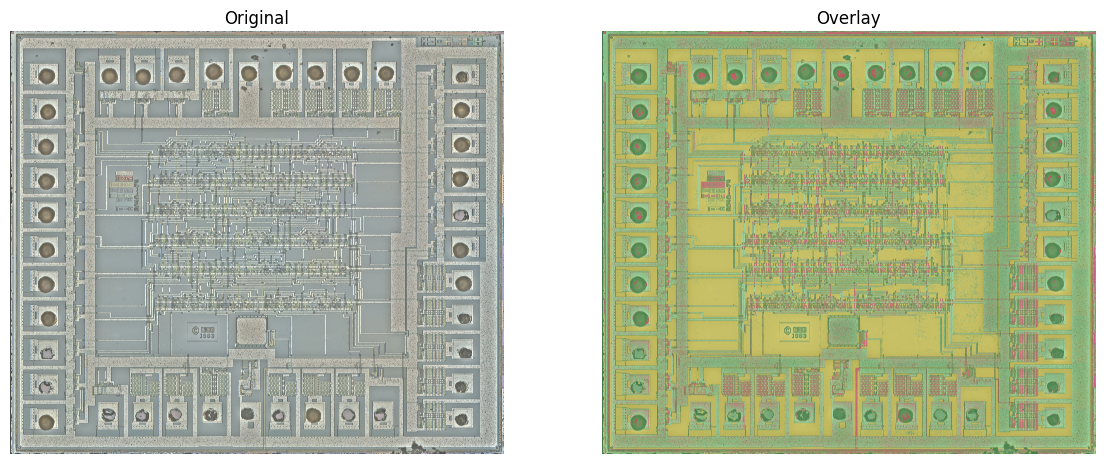

[samples_space detected = lab_gimp]
       metal:  60927048  ( 47.22%)
   substrate:  53546432  ( 41.50%)
        poly:  14556085  ( 11.28%)


In [2]:
label_map, class_names, paths, stats = segment_and_save(
    image_path="./images/die_flat.jpg",
    csv_path="./color_sample_lab.csv",
    outdir="out-lab",
    median_ks=3, open_ks=3, close_ks=3,
    priors=None,
    overlay_alpha=0.45,
    show=True,
    samples_space="lab_gimp"
)


# Post process clean up POLY halos

In [3]:
# === Fast metal > poly > substrate post-process (Jupyter-ready) ===
# - Removes any poly inside metal
# - Removes 1–4 px poly "halo" around metal
# - Optional fast pruning of band-only poly (no slow connected-components)
# - Rebuilds a clean label_map with exclusive layers (metal dominates)
#
# Usage at the bottom mirrors your call:
# label_map_clean, masks, info = clean_layer_stack(...)
# ratio, rstats = poly_adjacent_ratio(...)

import numpy as np
import cv2

# ---------- internal helper ----------
def _pick(name, class_names):
    """Case/substring-insensitive match of a desired class name within class_names."""
    if name is None:
        return None
    n = name.lower()
    for c in class_names:
        lc = c.lower()
        if n == lc or n in lc or lc in n:
            return c
    return name  # fall back to original

# ---------- main cleaner (fast) ----------
def clean_layer_stack_fast(
    label_map, class_names,
    metal_name="metal", poly_name="poly", substrate_name="substrate",
    diffusion_name=None,         # keep None since you dropped diffusion
    morph_ks=3,
    ring_r=3, band_r=None,       # try 3; move to 2 or 4 as needed
    close_then_open=True,
    prune_band_only=True,        # fast prune (no connectedComponents)
    max_iters=12,                # geodesic reconstruction iterations
    keep_unclassified_as_substrate=True
):
    """
    Enforce exclusive stack metal > poly > (diffusion) > substrate.
    Remove poly inside/around metal with a ring; then FAST-prune poly that lives only in the metal band
    by keeping band pixels connected to poly outside the band.

    Inputs:
      label_map : (H,W) int32 label indices
      class_names : list[str], maps indices -> names (e.g., ["metal","poly","substrate"])
      metal_name/poly_name/... : class names (matched case-insensitively)
      morph_ks : kernel for small stabilize (3 recommended)
      ring_r   : radius (px) of metal edge band to subtract from poly (2..4 typical)
      band_r   : band used for pruning (defaults to ring_r)
      prune_band_only : True keeps band pixels only if connected to poly outside band
      max_iters : iterations for geodesic reconstruction (small; band is thin)

    Returns:
      label_map_clean : (H,W) int32, same indexing as class_names
      masks : dict {name: uint8 0/255} for metal/poly/substrate ([diffusion] if provided)
      info : diagnostics dict
    """
    H, W = label_map.shape

    # Resolve names against class_names
    mn = _pick(metal_name, class_names)
    pn = _pick(poly_name, class_names)
    sn = _pick(substrate_name, class_names)
    dn = _pick(diffusion_name, class_names) if diffusion_name else None

    idx = {n:i for i,n in enumerate(class_names)}

    def mask_of(n):
        return ((label_map == idx[n]).astype(np.uint8)*255) if (n in idx) else np.zeros((H,W), np.uint8)

    M0 = mask_of(mn)
    P0 = mask_of(pn)
    D0 = mask_of(dn) if dn else np.zeros_like(M0)

    # 1) stabilize metal (close→open) with small kernel (won't fatten)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_ks, morph_ks))
    M = M0.copy()
    if close_then_open:
        M = cv2.morphologyEx(M, cv2.MORPH_CLOSE, k)
        M = cv2.morphologyEx(M, cv2.MORPH_OPEN,  k)

    # 2) hard exclusivity: remove metal from poly
    P1 = cv2.bitwise_and(P0, cv2.bitwise_not(M))

    # 3) subtract metal edge ring from poly
    ring_r = max(1, int(ring_r))
    kR  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*ring_r+1, 2*ring_r+1))
    dil = cv2.dilate(M, kR)
    ero = cv2.erode(M,  kR)
    ring = cv2.subtract(dil, ero)                 # 0/255 band
    P2   = cv2.bitwise_and(P1, cv2.bitwise_not(ring))

    # 4) FAST prune: keep band pixels only if connected to poly outside the band
    removed_px = 0
    if prune_band_only and np.any(P2):
        if band_r is None:
            band_r = ring_r
        band_r = max(1, int(band_r))
        kB   = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*band_r+1, 2*band_r+1))
        dilB = cv2.dilate(M, kB)
        eroB = cv2.erode(M,  kB)
        band = cv2.subtract(dilB, eroB)           # 0/255 band

        Pbin     = (P2 > 0).astype(np.uint8)      # 0/1
        outside  = cv2.bitwise_and(Pbin, (band==0).astype(np.uint8))
        bandpoly = cv2.bitwise_and(Pbin, (band>0).astype(np.uint8))

        # Geodesic reconstruction: grow from 'outside' within Pbin until stable
        keep = outside.copy()
        K3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        prev = -1
        for _ in range(int(max_iters)):
            dil_k = cv2.dilate(keep, K3)
            keep_new = cv2.bitwise_and(dil_k, Pbin)
            s = int(cv2.countNonZero(keep_new))
            if s == prev:
                keep = keep_new
                break
            keep = keep_new
            prev = s

        keep_band = cv2.bitwise_and(keep, bandpoly)
        P3 = ((outside > 0) | (keep_band > 0)).astype(np.uint8) * 255
        removed_px = int(cv2.countNonZero(P2) - cv2.countNonZero(P3))
        P2 = P3

    # 5) diffusion exclusive of (metal ∪ poly) — empty if dn is None
    MP = cv2.bitwise_or(M, P2)
    D  = cv2.bitwise_and(D0, cv2.bitwise_not(MP)) if dn else np.zeros_like(MP)

    # 6) substrate = remainder
    allu = cv2.bitwise_or(MP, D)
    S    = cv2.bitwise_not(allu)

    # 7) compose final labels by dominance
    L = np.full((H,W), -1, dtype=np.int32)
    if sn in idx: L[S>0]  = idx[sn]
    if dn and (dn in idx): L[D>0]  = idx[dn]
    if pn in idx: L[P2>0] = idx[pn]
    if mn in idx: L[M>0]  = idx[mn]
    if keep_unclassified_as_substrate and (sn in idx):
        L[L < 0] = idx[sn]

    masks = {mn: M, pn: P2, sn: S}
    if dn: masks[dn] = D
    info = {
        "metal_px": int(cv2.countNonZero(M)),
        "poly_px_raw": int(cv2.countNonZero(P0)),
        "poly_px_clean": int(cv2.countNonZero(P2)),
        "metal_ring_px": int(cv2.countNonZero(ring)),
        "poly_removed_halo_px": int(removed_px),
        "ring_r": int(ring_r),
        "band_r": int(band_r if band_r is not None else ring_r),
        "max_iters": int(max_iters),
    }
    return L, masks, info

# ---------- convenience: keep your old function name ----------
clean_layer_stack = clean_layer_stack_fast

# ---------- audit helper ----------
def poly_adjacent_ratio(masks, band_r=3, metal_key="metal", poly_key="poly"):
    """
    Fraction of poly pixels lying within a metal edge band of radius band_r.
    Lower is better (target < 0.05; ideally << 0.01).
    """
    M = masks.get(metal_key); P = masks.get(poly_key)
    if M is None or P is None or (cv2.countNonZero(P) == 0):
        return 0.0, {"poly_px": 0, "poly_in_band_px": 0}
    k   = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*band_r+1, 2*band_r+1))
    dm  = cv2.dilate(M, k); em = cv2.erode(M, k)
    band = cv2.subtract(dm, em)
    overlap = cv2.bitwise_and(P, band)
    poly_px = int(cv2.countNonZero(P))
    inband  = int(cv2.countNonZero(overlap))
    return inband / max(poly_px,1), {"poly_px": poly_px, "poly_in_band_px": inband}

# ---------- example run (edit names if your class names differ) ----------
# label_map_clean, masks, info = clean_layer_stack(
#     label_map, class_names,
#     metal_name="metal",          # adjust to your exact names if needed
#     poly_name="poly",
#     substrate_name="substrate",
#     diffusion_name=None,         # we dropped diffusion
#     morph_ks=3,
#     ring_r=3, band_r=3,          # try 3; move to 2 or 4 as needed
#     prune_band_only=True,
#     max_iters=12
# )
# ratio, rstats = poly_adjacent_ratio(masks, band_r=3, metal_key="metal", poly_key="poly")
# print(info, rstats, "adjacent_ratio=", f"{ratio:.5f}")


In [4]:
label_map_clean, masks, info = clean_layer_stack(
    label_map, class_names,
    metal_name="metal",
    poly_name="poly",
    substrate_name="substrate",
    diffusion_name=None,
    morph_ks=3,
    ring_r=3, band_r=3,
    prune_band_only=True,
    max_iters=12
)
ratio, rstats = poly_adjacent_ratio(masks, band_r=3, metal_key="metal", poly_key="poly")
print(info, rstats, "adjacent_ratio=", f"{ratio:.5f}")


{'metal_px': 64246607, 'poly_px_raw': 14556085, 'poly_px_clean': 3243348, 'metal_ring_px': 55526033, 'poly_removed_halo_px': 0, 'ring_r': 3, 'band_r': 3, 'max_iters': 12} {'poly_px': 3243348, 'poly_in_band_px': 0} adjacent_ratio= 0.00000


# Save POLY cleanup

In [5]:
import os, cv2, numpy as np

save_dir = "out-lab-clean"  # change if you like
os.makedirs(save_dir, exist_ok=True)

# Save cleaned binary masks
cv2.imwrite(os.path.join(save_dir, "mask_metal_clean.png"),      masks["metal"])
cv2.imwrite(os.path.join(save_dir, "mask_poly_clean.png"),       masks["poly"])
cv2.imwrite(os.path.join(save_dir, "mask_substrate_clean.png"),  masks["substrate"])

# Save the cleaned label map + class names (for easy reload later)
np.save(os.path.join(save_dir, "label_map_clean.npy"), label_map_clean)
with open(os.path.join(save_dir, "class_names.txt"), "w") as f:
    for name in class_names:
        f.write(name + "\n")

print("Saved to:", save_dir)


Saved to: out-lab-clean


# Save new Overlay

In [6]:
# Set your base image path:
image_path = "./images/die_flat.jpg"  # <- adjust

# Colorize the cleaned labels and blend
img_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
color = np.zeros((*label_map_clean.shape, 3), np.uint8)

# class_names likely ['substrate','poly','metal'] from the mask loader earlier
name_to_idx = {n:i for i,n in enumerate(class_names)}
palette = {
    "substrate": (30, 30, 30),   # dark gray
    "poly":      (180, 0, 200),  # magenta
    "metal":     (0, 220, 255),  # yellow-ish (BGR)
}
for n, idx in name_to_idx.items():
    color[label_map_clean == idx] = palette.get(n, (200,200,200))

overlay = cv2.addWeighted(color, 0.45, img_bgr, 0.55, 0)
cv2.imwrite(os.path.join(save_dir, "overlay_clean.png"), overlay)
print("Overlay saved:", os.path.join(save_dir, "overlay_clean.png"))

Overlay saved: out-lab-clean/overlay_clean.png


# Clean up thin METAL lines

In [8]:
# === Thin-Metal Cleanup + Diagnostics (drop-in) ===============================
# - Strips skinny metal "hairs" via opening
# - Drops tiny metal specks by area
# - Reports CC count before/after + total removed area
# - (Optional) overlay of removed pixels on the image
# - Rebuilds exclusive labels with your already-clean poly & substrate
#
# Required in memory: label_map_clean, masks (with "metal","poly","substrate"), class_names
# Call thin_metal_cleanup(...) at the bottom.

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def _to_u8(mask_bool_or_255):
    m = mask_bool_or_255
    if m.dtype != np.uint8:
        m = (m > 0).astype(np.uint8) * 255
    else:
        m = (m > 0).astype(np.uint8) * 255
    return m

def clean_thin_metal(
    metal_mask,
    min_width_px=3,        # removes features thinner than ~this many px (try 3, else 5)
    area_min=128,          # drop CCs smaller than this many pixels
    open_iterations=1
):
    """
    Returns:
      metal_clean (uint8 0/255),
      debug dict including CC before/after and removed mask
    """
    M = _to_u8(metal_mask)
    # CC before
    cc_before, labels_before = cv2.connectedComponents((M > 0).astype(np.uint8), connectivity=8)
    comps_before = cc_before - 1  # exclude background

    # 1) Opening (erode->dilate) with an elliptical kernel
    ksize = int(min_width_px)
    if ksize < 1: ksize = 1
    if ksize % 2 == 0: ksize += 1
    ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))
    M_open = cv2.morphologyEx(M, cv2.MORPH_OPEN, ker, iterations=int(open_iterations))

    # 2) Remove small components by area
    num, labels, stats, _ = cv2.connectedComponentsWithStats((M_open > 0).astype(np.uint8), connectivity=8)
    keep = np.zeros_like(M_open, dtype=np.uint8)
    removed_area = 0
    removed_comps = 0
    for lab in range(1, num):
        area = int(stats[lab, cv2.CC_STAT_AREA])
        if area >= int(area_min):
            keep[labels == lab] = 255
        else:
            removed_area += area
            removed_comps += 1

    # CC after
    cc_after, _ = cv2.connectedComponents((keep > 0).astype(np.uint8), connectivity=8)
    comps_after = cc_after - 1

    removed_mask = cv2.bitwise_and(M, cv2.bitwise_not(keep))  # what got removed
    dbg = {
        "opened_kernel": (ksize, ksize),
        "removed_small_components": int(removed_comps),
        "removed_small_area_px": int(removed_area),
        "cc_before": int(comps_before),
        "cc_after": int(comps_after),
        "metal_px_before": int(cv2.countNonZero(M)),
        "metal_px_after": int(cv2.countNonZero(keep)),
        "removed_px_total": int(cv2.countNonZero(removed_mask)),
        "removed_mask": removed_mask,   # uint8 0/255
    }
    return keep, dbg

def rebuild_labels_with_new_metal(
    label_map_clean, class_names,
    new_metal_mask, poly_mask=None,
    substrate_name="substrate", poly_name="poly", metal_name="metal"
):
    """
    Replace metal with new_metal_mask and enforce exclusivity:
      poly <- poly & ~metal
      substrate <- complement(metal ∪ poly)
    """
    H, W = label_map_clean.shape
    name2idx = {n:i for i,n in enumerate(class_names)}

    M = (_to_u8(new_metal_mask) > 0).astype(np.uint8)
    if poly_mask is None:
        P = (label_map_clean == name2idx.get(poly_name, -999)).astype(np.uint8)
    else:
        P = (_to_u8(poly_mask) > 0).astype(np.uint8)

    # Enforce exclusivity
    P = cv2.bitwise_and(P*255, cv2.bitwise_not(M*255)) // 255
    M = M.astype(np.uint8)
    MP = cv2.bitwise_or(M, P)
    S  = cv2.bitwise_not(MP*255) // 255

    # Write labels by dominance: substrate < poly < metal
    L = np.full((H,W), -1, dtype=np.int32)
    if substrate_name in name2idx: L[S>0] = name2idx[substrate_name]
    if poly_name      in name2idx: L[P>0] = name2idx[poly_name]
    if metal_name     in name2idx: L[M>0] = name2idx[metal_name]
    if substrate_name in name2idx: L[L<0] = name2idx[substrate_name]

    masks_new = {
        substrate_name: (S*255).astype(np.uint8),
        poly_name:      (P*255).astype(np.uint8),
        metal_name:     (M*255).astype(np.uint8),
    }
    return L, masks_new

def _save_if(path, img):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    cv2.imwrite(path, img)

def thin_metal_cleanup(
    label_map_clean, masks, class_names,
    image_path=None, save_dir=None,
    min_width_px=3, area_min=128, open_iterations=1,
    substrate_name="substrate", poly_name="poly", metal_name="metal",
    show=True
):
    """
    Wraps cleaning + diagnostics + optional overlay/saves.
    Returns: label_map_new, masks_new, report(dict)
    """
    metal_before = masks[metal_name]
    poly_mask    = masks[poly_name]

    metal_clean, dbg = clean_thin_metal(
        metal_before,
        min_width_px=min_width_px,
        area_min=area_min,
        open_iterations=open_iterations
    )

    # Overlay of removed pixels
    overlay_bgr = None
    if image_path and os.path.exists(image_path):
        img_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if img_bgr is not None and img_bgr.shape[:2] == metal_clean.shape[:2]:
            removed = dbg["removed_mask"]
            red = np.zeros_like(img_bgr); red[...,2] = 255
            mask3 = cv2.merge([removed, removed, removed])
            overlay_bgr = cv2.addWeighted(img_bgr, 1.0, cv2.bitwise_and(red, mask3), 0.6, 0)

    # Rebuild exclusive labels with new metal
    L_new, masks_new = rebuild_labels_with_new_metal(
        label_map_clean, class_names,
        new_metal_mask=metal_clean,
        poly_mask=poly_mask,
        substrate_name=substrate_name,
        poly_name=poly_name,
        metal_name=metal_name
    )

    report = {
        **dbg,
        "poly_px": int(cv2.countNonZero(masks_new[poly_name])),
    }

    # Save outputs if requested
    if save_dir:
        _save_if(os.path.join(save_dir, "mask_metal_thin.png"),      masks_new[metal_name])
        _save_if(os.path.join(save_dir, "mask_poly_clean.png"),      masks_new[poly_name])
        _save_if(os.path.join(save_dir, "mask_substrate_clean.png"), masks_new[substrate_name])
        if overlay_bgr is not None:
            _save_if(os.path.join(save_dir, "overlay_removed_metal.png"), overlay_bgr)
        # simple text report
        with open(os.path.join(save_dir, "thin_metal_report.txt"), "w") as f:
            for k,v in report.items():
                if k != "removed_mask":
                    f.write(f"{k}: {v}\n")

    # Show quick view
    if show:
        print("Metal clean debug:", {k:v for k,v in report.items() if k != "removed_mask"})
        if overlay_bgr is not None:
            plt.figure(figsize=(10,6))
            plt.imshow(cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB))
            plt.title("Removed metal (red) over image"); plt.axis('off')
            plt.show()

    return L_new, masks_new, report

# ---------------- Example call (edit paths/params if needed) ------------------
# L2, masks2, rep = thin_metal_cleanup(
#     label_map_clean, masks, class_names,
#     image_path="./images/die_flat.jpg",     # or None to skip overlay
#     save_dir="out-lab-thin",                # or None to skip saving
#     min_width_px=3,                         # try 3; if hairs remain, try 5
#     area_min=128,                           # drop specks <128 px; try 256 to be stricter
#     open_iterations=1,
#     metal_name="metal", poly_name="poly", substrate_name="substrate",
#     show=True
# )
# label_map_clean, masks = L2, masks2  # replace current with cleaned


Metal clean debug: {'opened_kernel': (5, 5), 'removed_small_components': 3515, 'removed_small_area_px': 625310, 'cc_before': 7747, 'cc_after': 4232, 'metal_px_before': 58651061, 'metal_px_after': 58025751, 'removed_px_total': 625310, 'poly_px': 3243348}


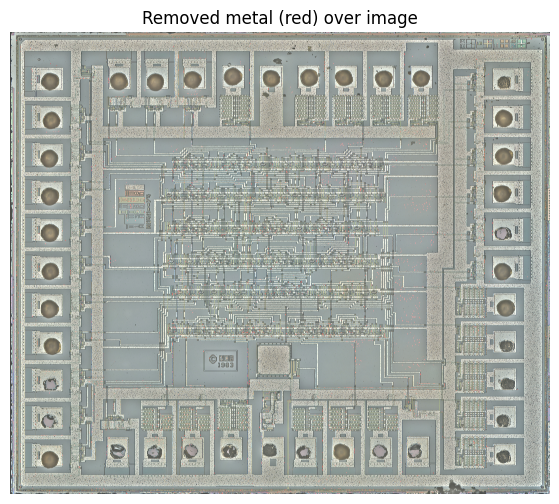

In [11]:
L2, masks2, rep = thin_metal_cleanup(
    label_map_clean, masks, class_names,
    image_path="./images/die_flat.jpg",   # optional; set None if not handy
    save_dir="out-lab-thin",
    min_width_px=5,
    area_min=256,
    open_iterations=1,
    metal_name="metal", poly_name="poly", substrate_name="substrate",
    show=True
)
label_map_clean, masks = L2, masks2  # adopt cleaned results
